In [ ]:
!pip install tqdm torch torchvision --quiet

In [2]:
import os
import torch
import copy
from tqdm.notebook import tqdm
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt


### Import data and split

In [3]:
def get_vids(path2imgs):
    listOfCats = os.listdir(path2imgs)
    print(listOfCats)
    ids = []
    labels = []
    for category in listOfCats:
        path2category = os.path.join(path2imgs, category)
        listOfvids = os.listdir(path2category)
        path2vids= [os.path.join(path2category,los) for los in listOfvids]
        ids.extend(path2vids)                       #extend adds each element of the list to the list being extend and not the whole list as 1 elem
        print([category.split('_')[0]]*len(listOfvids))
        labels.extend([category.split('_')[0]]*len(listOfvids))   #making the Y variable (labels are same for a list of videos)
    return ids, labels, listOfCats

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path2data = "/content/drive/MyDrive/AI_ML_project/dataset_ISL"
sub_folder_jpg = "Cropped_Frames"
path2imgs = os.path.join(path2data, sub_folder_jpg)

all_vids, all_labels, cats = get_vids(path2imgs)
cats = [name.split('_')[0] for name in cats]

print(len(all_vids))
print(len(all_labels))
all_vids

In [6]:
print(cats)
#assign int to each cat
labels_dict = {} #creating a dictonary for labels
ids = 0
for cat in cats:
    labels_dict[cat] = ids
    ids += 1


['accident', 'call', 'doctor', 'help', 'hot', 'lose', 'pain', 'thief']


## SPLIT DATA

In [44]:
# from sklearn.model_selection import StratifiedShuffleSplit

# sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=42)
# train_indx, test_indx = next(sss.split(all_vids, all_labels))

# train_ids = [all_vids[ind] for ind in train_indx]
# train_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in train_indx]
# print(len(train_ids), len(train_labels))
# print(train_labels)

# test_ids = [all_vids[ind] for ind in test_indx]
# test_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in test_indx]
# print(len(test_ids), len(test_labels))
# print(test_labels)

from sklearn.model_selection import StratifiedShuffleSplit

# Define the ratio for train, validation, and test sets
train_ratio = 0.9
validation_ratio = 0.05
test_ratio = 0.05

# Initialize StratifiedShuffleSplit for train and test split
sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=42)

# Get indices for train and test sets
train_indx, test_indx = next(sss_train_test.split(all_vids, all_labels))

print(type(train_indx))
# Convert indices to lists for slicing
train_indx = list(train_indx)
test_indx = list(test_indx)

# Get data for train, validation, and test sets
train_ids = [all_vids[ind] for ind in train_indx]
train_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in train_indx]
print("Train Set -", len(train_ids), "samples")
# print(train_labels)

# Use train indices for train and validation split
sss_train_validation = StratifiedShuffleSplit(n_splits=1, test_size=validation_ratio, random_state=42)
train_indx, validation_indx = next(sss_train_validation.split(train_ids, train_labels))

# Get data for train, validation, and test sets
train_ids = [all_vids[ind] for ind in train_indx]
train_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in train_indx]
print("Train Set -", len(train_ids), "samples")

val_ids = [all_vids[ind] for ind in validation_indx]
val_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in validation_indx]
print("Validation Set -", len(val_ids), "samples")
# print(val_labels)

test_ids = [all_vids[ind] for ind in test_indx]
test_labels = [all_vids[ind].split('/')[-1].split('_')[0] for ind in test_indx]
print("Test Set -", len(test_ids), "samples")
# print(test_labels)


<class 'numpy.ndarray'>
Train Set - 391 samples
Train Set - 371 samples
Validation Set - 20 samples
Test Set - 21 samples


### Defining dataset

In [45]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)
timesteps =16
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")

        path2imgs = path2imgs[:timesteps]

        # print(self.labels[idx])
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:

            frame = Image.open(p2i)
            frames.append(frame)

        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        # print(frames_tr)
        # print(label)
        return frames_tr, label

In [46]:
# choose one
model_type = "3dcnn"
#model_type = "rnn"


if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [47]:
import torchvision.transforms as transforms

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

In [48]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

371


In [49]:
imgs, label = train_ds[10]   #Each element of train_ds  is a set of images of that video and corresponding is the label
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 112, 112]), 6, tensor(-1.8952), tensor(2.3870))

In [50]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

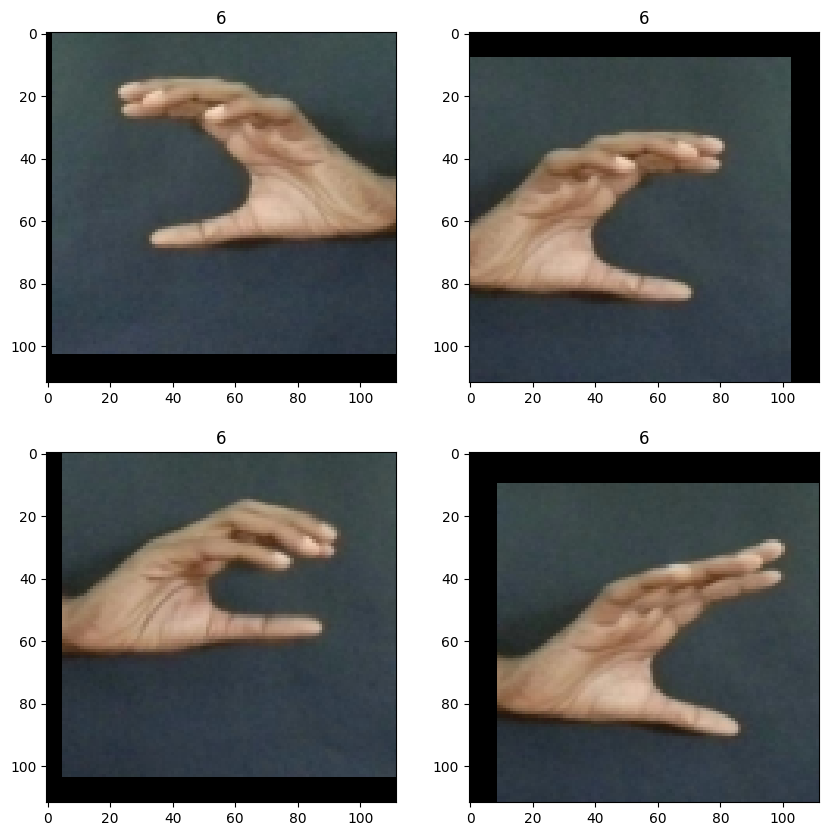

In [51]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

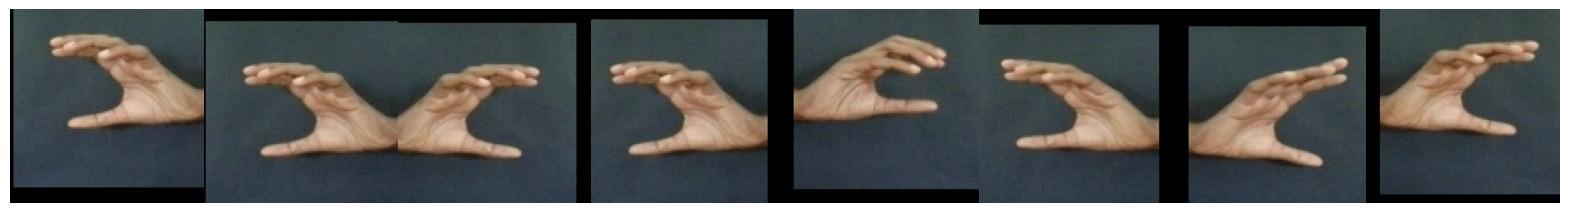

In [52]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii,img in enumerate(imgs[::2]):
    plt.subplot(1,8,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.axis("off")

In [53]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])
test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
val_ds = VideoDataset(ids= val_ids, labels= val_labels, transform= test_transformer)
print(len(test_ds))
print(len(val_ds))

21
20


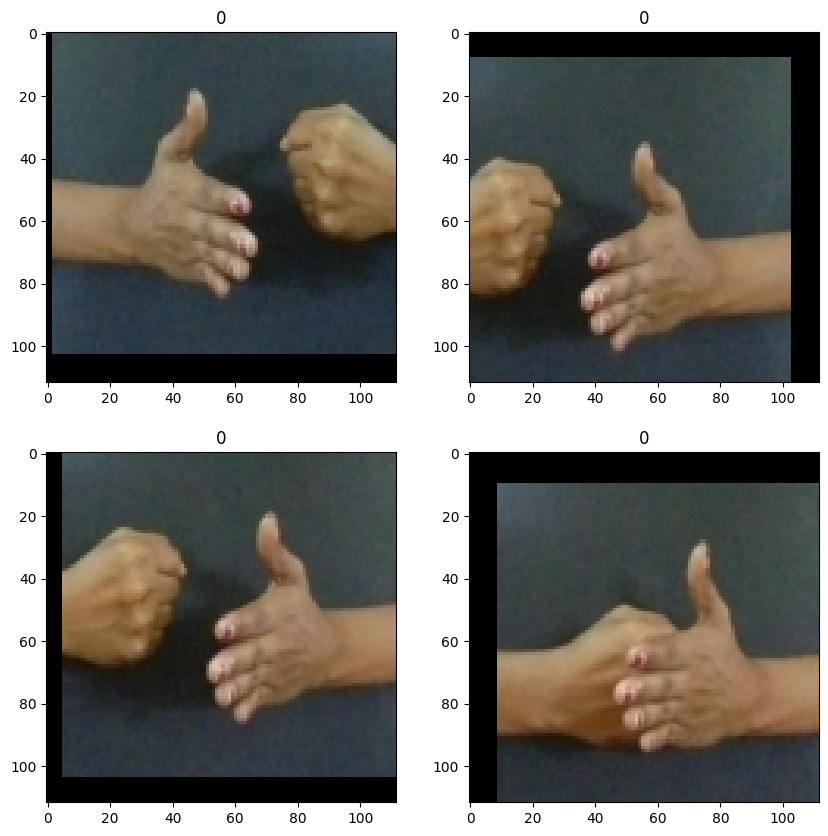

In [17]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

### Defining Dataloader

In [55]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor


batch_size = 32
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= batch_size//4,
                         shuffle=False, collate_fn= collate_fn_rnn)
    val_dl = DataLoader(val_ds, batch_size= batch_size//4,
                         shuffle=False, collate_fn= collate_fn_rnn)
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= batch_size//4,
                         shuffle=False, collate_fn= collate_fn_r3d_18)
    val_dl = DataLoader(val_ds, batch_size= batch_size//4,
                         shuffle=False, collate_fn= collate_fn_r3d_18)

In [57]:
for xb,yb in val_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([8, 3, 16, 112, 112]) torch.Size([8])


In [58]:
from torchvision import models
from torch import nn
from torch import nn

#defining our rnn model
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]

        baseModel = models.resnet18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers) #512, 100, 1
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out)
        return out

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x


In [59]:
from torch import nn
import os
from torchvision import models

# Create the directory if it does not exist
directory = "./models/"
os.makedirs(directory, exist_ok=True)
if model_type == "rnn":
    params_model={
        "num_classes": len(cats),
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}
    model = Resnt18Rnn(params_model)
else:
    model = models.video.r3d_18(pretrained=True, progress=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, len(cats))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(1, 16, 3, h, w)
    else:
        x = torch.zeros(1, 3, 16, h, w)
    y= model(x)
    print(y.shape)

torch.Size([1, 8])


In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [62]:
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [63]:
#path2weights = "./models/weights.pt"
path2weights = os.path.join(directory, "weights.pt")
torch.save(model.state_dict(), path2weights)

In [65]:
#Get the learning rate corresponding to optimizers
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


In [66]:
#loss of a particular batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        pred = output.argmax(dim=1, keepdim=True)
        corrects=pred.eq(target.view_as(pred)).sum().item()
        metric_b = corrects
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [67]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in tqdm(dataset_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss+=loss_b

        if metric_b is not None:
            running_metric+=metric_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric


In [68]:
#Function to train the model

def train_val(model, params , num_epochs):
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history={
        "train": [],
        "val": [],
    }

    metric_history={
        "train": [],
        "val": [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    for epoch in range(num_epochs):
        # print(opt.param_groups)
        for param_group in opt.param_groups:

            current_lr=param_group['lr']

        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
            #Store the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")

        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)


        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10)
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [69]:
import gc
gc.collect()

32549

In [31]:
#training the model
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
#os.makedirs("./models", exist_ok=True)

params_train={
    #"num_epochs": 20,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt",
    }
model,loss_hist,metric_hist = train_val(model,params_train , num_epochs =20)

Epoch 0/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.722593, dev loss: 1.566310, accuracy: 52.38
----------
Epoch 1/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.938203, dev loss: 1.038068, accuracy: 76.19
----------
Epoch 2/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.508370, dev loss: 0.718195, accuracy: 88.10
----------
Epoch 3/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.292637, dev loss: 0.537995, accuracy: 90.48
----------
Epoch 4/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.194391, dev loss: 0.420598, accuracy: 95.24
----------
Epoch 5/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.137371, dev loss: 0.358654, accuracy: 95.24
----------
Epoch 6/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.089274, dev loss: 0.294358, accuracy: 95.24
----------
Epoch 7/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.077791, dev loss: 0.253402, accuracy: 97.62
----------
Epoch 8/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.064158, dev loss: 0.236070, accuracy: 95.24
----------
Epoch 9/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.049892, dev loss: 0.218493, accuracy: 97.62
----------
Epoch 10/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.045573, dev loss: 0.202815, accuracy: 95.24
----------
Epoch 11/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.039246, dev loss: 0.192281, accuracy: 95.24
----------
Epoch 12/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.030226, dev loss: 0.168440, accuracy: 100.00
----------
Epoch 13/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.029408, dev loss: 0.162590, accuracy: 100.00
----------
Epoch 14/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.030854, dev loss: 0.146245, accuracy: 100.00
----------
Epoch 15/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.022186, dev loss: 0.141959, accuracy: 100.00
----------
Epoch 16/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.024821, dev loss: 0.138414, accuracy: 100.00
----------
Epoch 17/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.020137, dev loss: 0.120391, accuracy: 100.00
----------
Epoch 18/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.017152, dev loss: 0.123137, accuracy: 100.00
----------
Epoch 19/19, current lr=3e-05


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.013104, dev loss: 0.118219, accuracy: 100.00
----------


In [34]:
def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

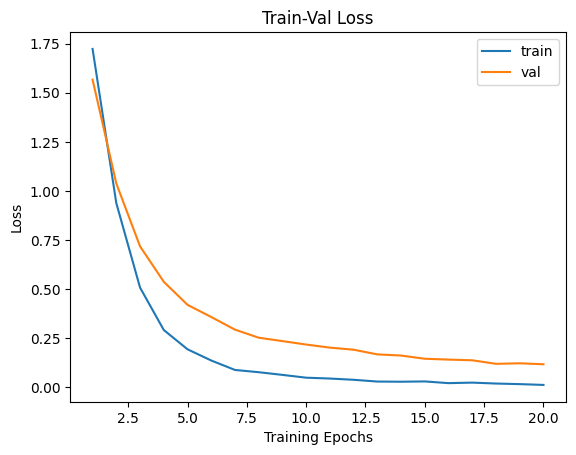

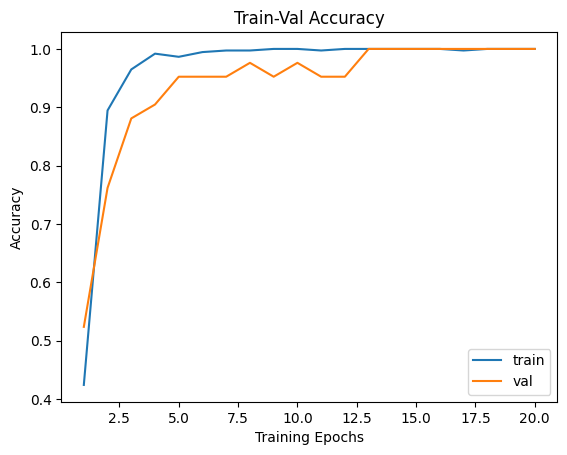

In [33]:
plot_loss(loss_hist, metric_hist)